# RetinaMNIST with rotations

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during the lecture about Object Detection. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits **from 1 to 5** randomly selected from `MNIST` dataset on a canvas of size `(128, 128)` and **randomly flipped by 90 degrees**. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [ ]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import pandas as pd
import plotly.express as px


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
        rotated: Optional[bool] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
        self.rotated = rotated
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}.' +\
               f' Rotated = {self.rotated}.'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        ax.text(
            self.y_min,
            self.x_min,
            f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        rotated=None,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
            class_nb=class_nb,
            rotated=rotated,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [ ]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)
    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit_class = classes[current_digit_index]
        if current_digit_class not in [1, 2, 3, 4, 5]:
            continue
        rotate = np.random.random() > 0.5
        current_digit = digits[current_digit_index]
        if rotate:
            current_digit = np.rot90(current_digit)
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=current_digit_class,
            rotated=rotate,
        ):
            attempts_done += 1
    return new_canvas

11501568/11490434 [==============================] - 0s 0us/step


Let us have a look at example canvas (rotated digits have additional *added to description).

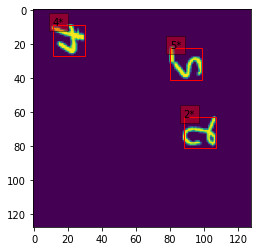

In [ ]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

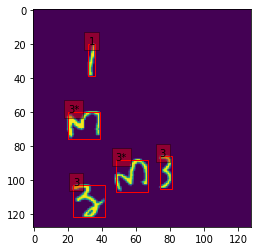

In [ ]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (2pts)

For this task:
1. Sample at least 1000 random canvas.
2. Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

In [ ]:
import collections
import matplotlib.pyplot as plt


ANALYZE_CANVAS_SIZE = 1000

ANALYZE_CANVAS = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(ANALYZE_CANVAS_SIZE)
]

x_len = []
y_len = []
sizes = []
areas = []
ratios = []
for canvas in ANALYZE_CANVAS:
    for box in canvas.boxes:
        areas.append(box.x_diff*box.y_diff)
        ratios.append(box.x_diff/box.y_diff)
        sizes.append([box.x_diff,box.y_diff])
        x_len.append(box.x_diff)
        y_len.append(box.y_diff)


# Mine IoU

def intersection_over_union(box1, box2):
  x_min = min(box1[0], box2[0])
  y_min = min(box1[1], box2[1])
  intersection_area = x_min*y_min

  box1_area = box1[0]*box1[1]
  box2_area = box2[0]*box2[1]

  iou = intersection_area/(box1_area+box2_area-intersection_area)
  return iou

# k-means using IoU



# **K-means algorithm for choosing the efficient number of anchors and their sizes.**

To analyze anchors, I will implement the k-means algorithm with the IoU metric. Similar anchors will have high IoU. The algorithm will cluster them. We can say that number of anchors and their sizes are hyperparameters.

In [ ]:
def kmeans(K, X):
  dists = np.zeros(shape = (X.shape[0],K))
  random_idx = np.random.permutation(X.shape[0])
  centroids = X[random_idx[:K]]
  X_with_labels = []
  labels = np.zeros(shape = (X.shape[0],1))
  X_with_labels = np.append(X, labels, axis=1)
  for epoch in range(100):
    for j in range(K):
      for i in range(len(sizes)):
        dists[i,j] = intersection_over_union(sizes[i], centroids[j])
    label = np.argmax(dists, axis = 1)
    X_with_labels[:,-1] = label
    for l in range(K):
      labels = X_with_labels[X_with_labels[:,2]==l]
      if len(labels) !=0:
        centroids[l] = np.mean(X_with_labels[X_with_labels[:,2]==l], axis=0)[:-1]
        print(centroids)
  return X_with_labels

In [ ]:
sizes = np.array(sizes)
iou_means = []
iou = []
def iou_means_calc(K, sizes):
  iou_means = []
  iou = []
  test = kmeans(K, sizes)
  for k in range(test.shape[1]):
    test_k = test[test[:,2] == k]
    test_k = np.delete(test_k, -1, axis=1)
    for i in range(test_k.shape[0]):
      for j in range(test_k.shape[0]):
        iou.append(intersection_over_union(test_k[i], test_k[j]))
    iou_means.append(np.mean(iou))
  return np.mean(iou_means)

In [ ]:
means = []
for i in range(1,15):
  mean = iou_means_calc(i, sizes)
  means.append(mean)

Streaming output truncated to the last 5000 lines.
 [19  5]
 [19 16]]
[[15 19]
 [ 6 19]
 [19 13]
 [ 7 19]
 [12 19]
 [18 18]
 [ 2 19]
 [19 10]
 [ 4 19]
 [ 9 19]
 [ 5 19]
 [ 3 19]
 [19  5]
 [19 16]]
[[15 19]
 [ 6 19]
 [19 13]
 [ 7 19]
 [12 19]
 [18 18]
 [ 2 19]
 [19 10]
 [ 4 19]
 [ 9 19]
 [ 5 19]
 [ 3 19]
 [19  5]
 [19 16]]
[[15 19]
 [ 6 19]
 [19 13]
 [ 7 19]
 [12 19]
 [18 18]
 [ 2 19]
 [19 10]
 [ 4 19]
 [ 9 19]
 [ 5 19]
 [ 3 19]
 [19  5]
 [19 16]]
[[15 19]
 [ 6 19]
 [19 13]
 [ 7 19]
 [12 19]
 [18 18]
 [ 2 19]
 [19 10]
 [ 4 19]
 [ 9 19]
 [ 5 19]
 [ 3 19]
 [19  5]
 [19 16]]
[[15 19]
 [ 6 19]
 [19 13]
 [ 7 19]
 [12 19]
 [18 18]
 [ 2 19]
 [19 10]
 [ 4 19]
 [ 9 19]
 [ 5 19]
 [ 3 19]
 [19  5]
 [19 16]]
[[15 19]
 [ 6 19]
 [19 13]
 [ 7 19]
 [12 19]
 [18 18]
 [ 2 19]
 [19 10]
 [ 4 19]
 [ 9 19]
 [ 5 19]
 [ 3 19]
 [19  5]
 [19 16]]
[[15 19]
 [ 6 19]
 [19 13]
 [ 7 19]
 [12 19]
 [18 18]
 [ 2 19]
 [19 10]
 [ 4 19]
 [ 9 19]
 [ 5 19]
 [ 3 19]
 [19  5]
 [19 16]]
[[15 19]
 [ 6 19]
 [19 13]
 [ 7 19]
 [12 

The high number of anchors can improve the mean IoU measure. However, at a cost of increasing the computation cost and overfitting, which may result in long training and poor results in test data.

As we can see on the plot, the optimal number of anchors is 10, because adding more does not increase mean the IoU significantly. 

In [ ]:
x = range(1,15)
df = pd.DataFrame(means, columns = ['iou_means'])
df['X'] = x
df
fig = px.line(df, x= x, y='iou_means', title = "Iou means for diffrent K in K-means algorithm")
fig.show()

In [ ]:
test = kmeans(10, sizes)

Streaming output truncated to the last 5000 lines.
[[ 4 19]
 [ 7 19]
 [19 16]
 [18 18]
 [16 19]
 [10 19]
 [19 10]
 [19 13]
 [13 19]
 [19  5]]
[[ 4 19]
 [ 7 19]
 [19 16]
 [18 18]
 [16 19]
 [10 19]
 [19 10]
 [19 13]
 [13 19]
 [19  5]]
[[ 4 19]
 [ 7 19]
 [19 16]
 [18 18]
 [16 19]
 [10 19]
 [19 10]
 [19 13]
 [13 19]
 [19  5]]
[[ 4 19]
 [ 7 19]
 [19 16]
 [18 18]
 [16 19]
 [10 19]
 [19 10]
 [19 13]
 [13 19]
 [19  5]]
[[ 4 19]
 [ 7 19]
 [19 16]
 [18 18]
 [16 19]
 [10 19]
 [19 10]
 [19 13]
 [13 19]
 [19  5]]
[[ 4 19]
 [ 7 19]
 [19 16]
 [18 18]
 [16 19]
 [10 19]
 [19 10]
 [19 13]
 [13 19]
 [19  5]]
[[ 4 19]
 [ 7 19]
 [19 16]
 [18 18]
 [16 19]
 [10 19]
 [19 10]
 [19 13]
 [13 19]
 [19  5]]
[[ 4 19]
 [ 7 19]
 [19 16]
 [18 18]
 [16 19]
 [10 19]
 [19 10]
 [19 13]
 [13 19]
 [19  5]]
[[ 4 19]
 [ 7 19]
 [19 16]
 [18 18]
 [16 19]
 [10 19]
 [19 10]
 [19 13]
 [13 19]
 [19  5]]
[[ 4 19]
 [ 7 19]
 [19 16]
 [18 18]
 [16 19]
 [10 19]
 [19 10]
 [19 13]
 [13 19]
 [19  5]]
[[ 4 19]
 [ 7 19]
 [19 16]
 [18 18]
 [1

Chosen anchors sizes are:

[[19,  5],
 [10, 19],
 [14, 19],
 [18, 18],
 [19, 12],
 [ 5, 19],
 [19,  8],
 [19,  2],
 [19, 15],
 [19,  3]]

In [ ]:
df = pd.DataFrame(test, columns = ['x', 'y', 'label'])
fig = px.scatter(df, x="x", y="y", color="label")
fig.show()

### Model building (2pt)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

We provided you with a backbone model architecture that accepts a `MnistCanvas` instance and output a tensor with shape $(1, 16, 16, 128)$. It should be trained together with the rest of your solution.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 8, \left(n + \frac{1}{2}\right) * 8\right)$  for $m, n \in \{0, 1, \dots, 16 - 1\}$,

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{digitClassificationHead}$:

$\texttt{digitClassificationHead}$ should accept backbone output as an input and output `digit_classification_output` tensor of shape $(len(\texttt{anchors)}, 5)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j + 1$ (ground truth box).

#### $\texttt{rotationClassificationHead}$:

$\texttt{rotationClassificationHead}$ should accept backbone output as an input and output `rotation_classification_output` tensor of shape $(len(\texttt{anchors)}, 2)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit which was not rotated when $j = 0$ and was rotated when $j = 1$.

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$ where the value $br_{i}$ which is the value of i-th row has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$ 
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$ 
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$ 
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$ 

#### *Hint*: be careful with a construction of a head output as a simple reshaping might cause unexpected permutation of anchors.

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

In [ ]:
ANCHOR_SIZES = [[19,  5],
 [10, 19],
 [14, 19],
 [18, 18],
 [19, 12],
 [ 5, 19],
 [19,  8],
 [19,  2],
 [19, 15],
 [19,  3]]
boxes = []
for m in range(16):
  for n in range(16):
    for anchor in ANCHOR_SIZES:
              coord = (anchor[0], anchor[1], (m+1/2)*8, (n+1/2)*8)
              x_min = (m+1/2)*8 - (anchor[0])/2
              y_min = (n+1/2)*8 - (anchor[1])/2
              x_max = (m+1/2)*8 + (anchor[0])/2
              y_max = (n+1/2)*8 + (anchor[1])/2
              boxes.append((x_min, y_min, x_max, y_max))
anchors = []
for i in range(len(boxes)):
          anchors.append(MnistBox(boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3], class_nb = None))

The model architecture is the same as in RetinaNet. 

In [ ]:
from torch import nn
import numpy as np




class DigitDetectionModelOutput:

    def __init__(
        self,
        anchors: List[MnistBox],
        digit_classification_output: torch.Tensor,
        rotation_classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.digit_classification_output = digit_classification_output
        self.box_regression_output = box_regression_output
        self.rotation_classification_output = rotation_classification_output


class Backbone(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.output_shape = (16, 16, 128)
        self.first_block = torch.nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.blocks = torch.nn.ModuleList(
            [torch.nn.Sequential(*[
                nn.Conv2d(16 * (2 ** i), 16 * (2 ** (i + 1)), (3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
              ]) for i in range(1, 3)
            ]
        )

    def forward(self, x: MnistCanvas) -> torch.Tensor:
        image = torch.Tensor(x.image).to(DEVICE).view(1, 1, 128, 128)
        aux = self.first_block(image)
        for block in self.blocks:
            aux = block(aux)
        return aux


class DigitClassificationHead(torch.nn.Module):
  
  def __init__(self):
    super().__init__()
    self.conv = torch.nn.Sequential(
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 5*10, (3, 3), padding=1),)
  def forward(self, backbone_output):
      output = self.conv(backbone_output)
      output = output.permute(0, 2, 3, 1) #this will make sure reshape will work okay
      digit_classification_output = output.reshape(-1, 5)
      return digit_classification_output

class RotationClassificationHead(torch.nn.Module):
  
  def __init__(self):
    super().__init__()
    self.conv = torch.nn.Sequential(
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 2*10, (3, 3), padding=1),)

  def forward(self, backbone_output):
      output = self.conv(backbone_output)
      output = output.permute(0, 2, 3, 1)
      rotation_classification_output = output.reshape(-1, 2)
      return rotation_classification_output

class BoxRegressionHead(torch.nn.Module):
  
  def __init__(self):
    super().__init__()
    self.conv = torch.nn.Sequential(
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 4*10, (3, 3), padding=1),)
  def forward(self, backbone_output):
      output = self.conv(backbone_output)
      output = output.permute(0, 2, 3, 1)
      box_regression_output = output.reshape(-1, 4)
      return box_regression_output



class DigitDetectionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.digit_classification_output = DigitClassificationHead()
        self.rotation_classification_output = RotationClassificationHead()
        self.box_regression_output = BoxRegressionHead()
        self.backbone = Backbone()
        self.anchors = []


    def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:
      backbone_output = self.backbone(x)
      digit_classification_output = self.digit_classification_output(backbone_output)

      rotation_classification_output = self.rotation_classification_output(backbone_output)

      box_regression_output = self.box_regression_output(backbone_output)

      return DigitDetectionModelOutput(anchors, digit_classification_output, rotation_classification_output, box_regression_output)

### Significant overlap (4pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `digit_classification_target` - a tensor of shape $(len(anchors), 5)$,
- `rotation_classification_target` - a tensor of shape $(len(anchors), 2)$
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner: 

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$ 
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$ 
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$ 
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

`digit_classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{digit_classification_target}[i, \texttt{gt_best.class_nb} - 1] = 1.$$

`rotation_classification_target` should encode if matched `gt_best` has a digit which was rotated, namely:

$$\texttt{rotation_classification_target}[i, 0] = 1,$$

if `gt_best` digit was not rotated and:

$$\texttt{rotation_classification_target}[i, 1] = 1,$$

if `gt_best` digit was rotated (this might be interpreted as a one-hot encoding if a digit was rotated).

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [ ]:
from torchvision.ops import box_iou, nms

class DigitDetectionModelTarget:

    def __init__(
        self,
        digit_classification_target: torch.Tensor,
        rotation_classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):  
        self.digit_classification_target = digit_classification_target
        self.rotation_classification_target = rotation_classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors

class TargetDecoder:

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float = 0.2,
        nb_of_classes: int = 5,)-> DigitDetectionModelTarget:
          anchor_points = []
          for anchor in anchors: # I save anchor's x_min... to a list
            anchor_points.append([anchor.x_min, anchor.y_min, anchor.x_max, anchor.y_max])
          anchor_points = torch.tensor(anchor_points)
          canvas_points = []
          for box in canvas.boxes: # I save box'es x_min... to a list
            canvas_points.append([box.x_min, box.y_min, box.x_max, box.y_max])
          canvas_points = torch.tensor(canvas_points)
          iou_boxes = box_iou(anchor_points, canvas_points)
          box_regression_target = torch.zeros((len(anchors), 4))
          digit_classification_target = torch.zeros((len(anchors), 5))
          rotation_classification_target = torch.zeros((len(anchors), 2))
          matched_anchors = []
          for i in range(len(anchors)):
            if (iou_boxes[i,:] > iou_threshold).any() :
              gt_idx = iou_boxes[i,:].argmax()
              gt_best = canvas.boxes[gt_idx]
              box_regression_target[i,0] = gt_best.x_min - anchors[i].x_min
              box_regression_target[i,1] = gt_best.x_max - anchors[i].x_max
              box_regression_target[i,2] = gt_best.y_min - anchors[i].y_min
              box_regression_target[i,3] = gt_best.y_max - anchors[i].y_max
              digit_classification_target[i, gt_best.class_nb - 1] = 1
              rotation_classification_target[i, gt_best.rotated] = 1
              matched_anchors.append(i)
          return DigitDetectionModelTarget(digit_classification_target.to(DEVICE), rotation_classification_target.to(DEVICE), box_regression_target.to(DEVICE), matched_anchors)
    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
      prediction = []
      final_prediction = []
      anchor_points = []
      scores = []
      for i in range(len(model_output.anchors)):
        if torch.max(torch.sigmoid(model_output.digit_classification_output[i])) > 0.6: #filter only high probability model outputs
          prediction.append(MnistBox(
            (model_output.anchors[i].x_min + model_output.box_regression_output[i, 0]).detach().cpu().numpy(),
            (model_output.anchors[i].y_min + model_output.box_regression_output[i, 2]).detach().cpu().numpy(),
            (model_output.anchors[i].x_max + model_output.box_regression_output[i, 1]).detach().cpu().numpy(),
            (model_output.anchors[i].y_max + model_output.box_regression_output[i, 3]).detach().cpu().numpy(),
            (torch.argmax(model_output.digit_classification_output[i]) + 1).detach().cpu().numpy(),
            torch.max(torch.sigmoid((model_output.rotation_classification_output[i])))>0.6
          ))
          #print(model_output.rotation_classification_output[i])
          scores.append(torch.max(torch.sigmoid(model_output.digit_classification_output[i])))
          anchor_points.append([model_output.anchors[i].x_min + model_output.box_regression_output[i, 0]
                                , model_output.anchors[i].y_min + model_output.box_regression_output[i, 2], 
                                model_output.anchors[i].x_max + model_output.box_regression_output[i, 1], 
                                model_output.anchors[i].y_max + model_output.box_regression_output[i, 3]])
      anchor_points = torch.tensor(anchor_points)
      if anchor_points.shape[0] == 0:
        return None
      else:
        scores = torch.tensor(scores)
        scores = torch.sigmoid(scores)
        nms_predictions = nms(anchor_points, scores, iou_threshold = 0.11) # non-max supresion
        for k in nms_predictions:
          final_prediction.append(prediction[k])
      return final_prediction
      
         

In [ ]:
TEST_CANVAS[0]
model = DigitDetectionModel()

In [ ]:
output = model(TEST_CANVAS[0])
torch.max(torch.sigmoid((output.rotation_classification_output[2])))>0.6

tensor(False)

In [ ]:
TEST_CANVAS[0]

### Metrics (4pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`: 

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between digit predictions and targets,
- `torchvision.ops.sigmoid_focal_loss` between rotation predictions and targets,

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class  and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [ ]:
import torch
import torchvision 

class RetinaLoss:

    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]:
      matched_anchors = model_target.matched_anchors
      retina_loss = 0
      if not matched_anchors:
        return None
      box_regression_loss = torch.nn.functional.smooth_l1_loss(model_output.box_regression_output, model_target.box_regression_target, reduction='mean')/ len(matched_anchors)
      #target_class = model_target.digit_classification_target
      #output_class = model_output.digit_classification_output
      class_loss = torchvision.ops.sigmoid_focal_loss(model_output.digit_classification_output, model_target.digit_classification_target, reduction='mean', alpha = 0.9)
      #target_rotation = model_target.rotation_classification_target
      #output_rotation = model_output.rotation_classification_output
      rotation_loss = torchvision.ops.sigmoid_focal_loss(model_output.rotation_classification_output, model_target.rotation_classification_target, reduction='mean', alpha = 0.9)
      retina_loss = class_loss + box_regression_loss + rotation_loss
      #print(retina_loss)
      return retina_loss


class DigitAccuracy:

    def compute_metric  (
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
      matching = 0
      if not predicted_boxes:
        return matching
      else:
        if len(canvas.boxes) == len(predicted_boxes):
          for box_predicted in predicted_boxes:
            for box_canvas in canvas.boxes:
              if (box_predicted.class_nb == box_canvas.class_nb) and (box_predicted.rotated == box_canvas.rotated):
                box_predicted_points = [box_predicted.x_min, box_predicted.y_min, box_predicted.x_max, box_predicted.y_max]
                box_predicted_points = torch.tensor(np.array(box_predicted_points))
                box_predicted_points = box_predicted_points.view(1,4)
                box_canvas_points = [box_canvas.x_min, box_canvas.y_min, box_canvas.x_max, box_canvas.y_max]
                box_canvas_points = torch.tensor(box_canvas_points)
                box_canvas_points = box_canvas_points.view(1,4)
                iou = box_iou(box_predicted_points, box_canvas_points)
                if iou > 0.5:
                    matching += 1
        if matching == len(canvas.boxes):
          return 1
        else:
          return 0

### Train your model (4pt)

One should use all classes defined above to train the model.

A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

Plot example results of matched and mismatched predictions (2pt).

**Hint:** Training can take a while to achieve the expected accuracy. It is normal that for many epochs at the beginning accuracy is constantly $0$. Do not worry as long as the loss is on average decreasing across epochs.

Have fun!

In [ ]:
train_data_size = 1000

train_data = [
    get_random_canvas(
        digits=TRAIN_DIGITS,
        classes=TRAIN_CLASSES,
    )
    for _ in range(train_data_size)
]

In [ ]:
DEVICE

device(type='cpu')

In [ ]:
import torch.optim as optim

target_decoder = TargetDecoder()
digit_accuracy = DigitAccuracy()
n_epochs = 10

retina_loss = RetinaLoss()
lr = 0.0005


model = DigitDetectionModel()
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)

def train(model, train_data, optim):
    model.train()

    train_loss = 0
    train_correct = 0

    for i, data in enumerate(train_data):
        optimizer.zero_grad()
        output = model(data)
        target = target_decoder.get_targets(data, output.anchors)
        loss = retina_loss.compute_loss(output, target)
        if loss is not None:
          train_loss += loss.item()
          pred = target_decoder.get_predictions(output)
          train_correct += digit_accuracy.compute_metric(pred, data)
          loss.backward()
          optimizer.step()
        if i%10 == 0:
          print(loss)

    return train_loss / len(train_data), train_correct * 100 / len(train_data)


def test(model, test_data):
    model.eval()

    test_loss = 0
    test_correct = 0

    for i, data in enumerate(test_data):
        output = model(data)
        target = target_decoder.get_targets(data, output.anchors)
        loss = retina_loss.compute_loss(output, target)
        test_loss += loss.item()
        pred = target_decoder.get_predictions(output)
        test_correct += digit_accuracy.compute_metric(pred, data)
        if pred:
          canva = MnistCanvas(data.image, pred)
          canva.plot()

    return test_loss / len(test_data), test_correct * 100 / len(test_data)


for epoch in range(n_epochs):
  print(epoch)
  train(model, train_data, optimizer)

0
tensor(0.0386, grad_fn=<AddBackward0>)
tensor(0.0265, grad_fn=<AddBackward0>)
tensor(0.0290, grad_fn=<AddBackward0>)
tensor(0.0252, grad_fn=<AddBackward0>)
tensor(0.0296, grad_fn=<AddBackward0>)
tensor(0.0151, grad_fn=<AddBackward0>)
tensor(0.0119, grad_fn=<AddBackward0>)
tensor(0.0084, grad_fn=<AddBackward0>)
tensor(0.0088, grad_fn=<AddBackward0>)
tensor(0.0067, grad_fn=<AddBackward0>)
tensor(0.0115, grad_fn=<AddBackward0>)
tensor(0.0108, grad_fn=<AddBackward0>)
tensor(0.0072, grad_fn=<AddBackward0>)
tensor(0.0108, grad_fn=<AddBackward0>)
tensor(0.0082, grad_fn=<AddBackward0>)
tensor(0.0076, grad_fn=<AddBackward0>)
tensor(0.0086, grad_fn=<AddBackward0>)
tensor(0.0067, grad_fn=<AddBackward0>)
tensor(0.0090, grad_fn=<AddBackward0>)
tensor(0.0110, grad_fn=<AddBackward0>)
tensor(0.0101, grad_fn=<AddBackward0>)
tensor(0.0095, grad_fn=<AddBackward0>)
tensor(0.0074, grad_fn=<AddBackward0>)
tensor(0.0101, grad_fn=<AddBackward0>)
tensor(0.0093, grad_fn=<AddBackward0>)
tensor(0.0102, grad_fn=

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

torch.save(model, "/content/gdrive/My Drive/model_Retina")

Mounted at /content/gdrive


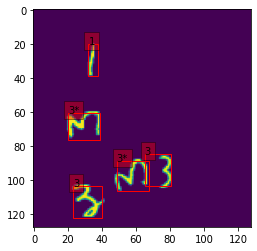

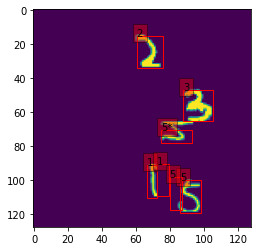

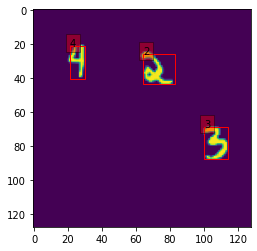

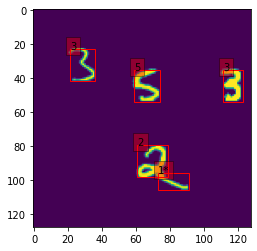

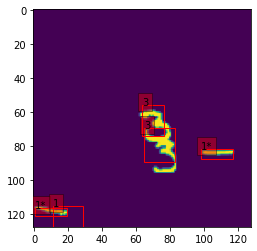

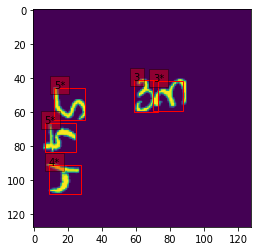

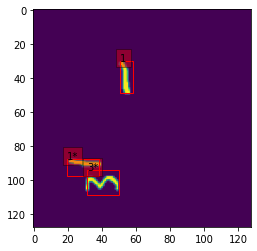

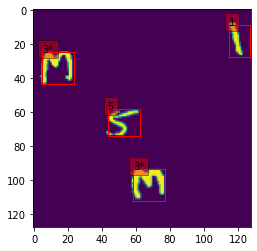

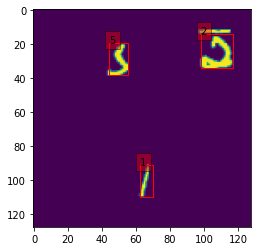

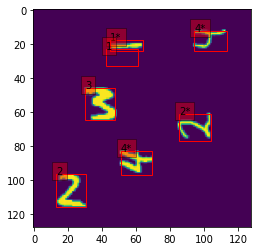

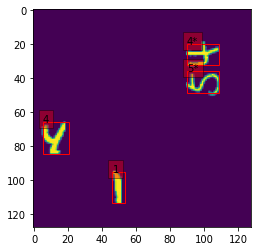

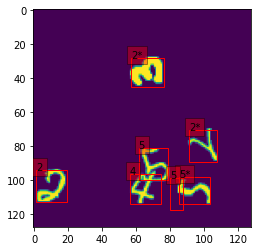

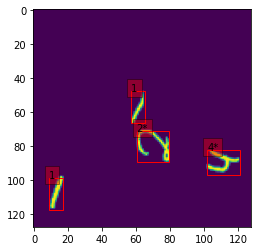

(0.003289967896307644, 55.078125)

In [ ]:
def test(model, test_data):
    model.eval()

    test_loss = 0
    test_correct = 0

    for i, data in enumerate(test_data):
        output = model(data)
        target = target_decoder.get_targets(data, output.anchors)
        loss = retina_loss.compute_loss(output, target)
        test_loss += loss.item()
        pred = target_decoder.get_predictions(output)
        test_correct += digit_accuracy.compute_metric(pred, data)
        if pred:
          if i% 20 ==0:
            canva = MnistCanvas(data.image, pred)
            canva.plot()

    return test_loss / len(test_data), test_correct * 100 / len(test_data)

test(model, TEST_CANVAS)

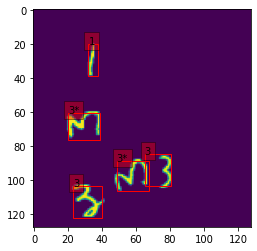

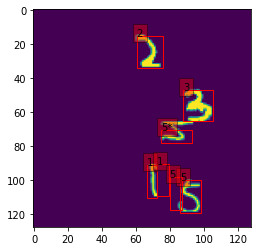

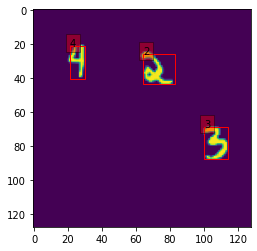

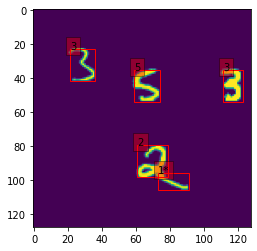

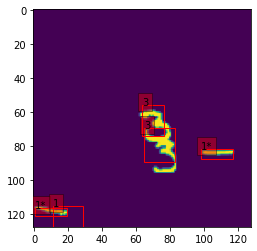

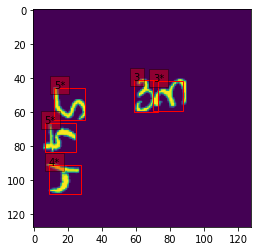

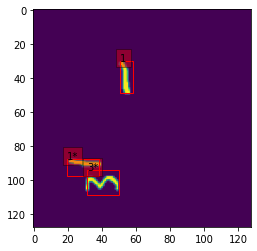

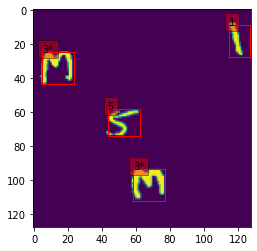

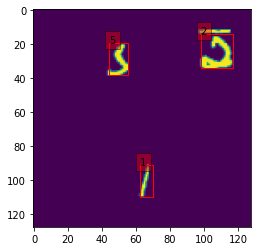

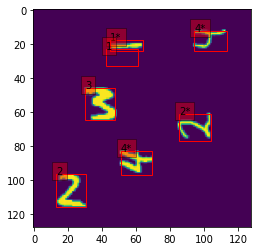

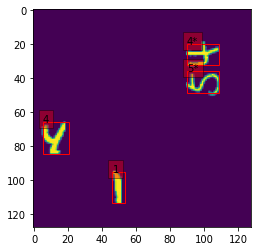

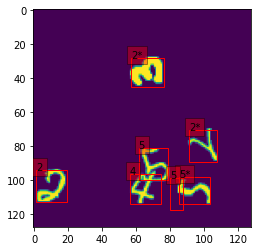

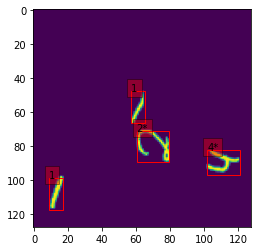

(0.003289967896307644, 55.078125)

In [ ]:
model_Retina = torch.load("/content/gdrive/My Drive/model_Retina")

test(model_Retina, TEST_CANVAS)

# **Summary**

**1. Anchor size analysis.**

*  To analyze anchors, I implemented k-means algorithm with IoU metric.
*  Optimal nubmer of anchors is 10, and their sizes are: [[19,  5],
 [10, 19],
 [14, 19],
 [18, 18],
 [19, 12],
 [ 5, 19],
 [19,  8],
 [19,  2],
 [19, 15],
 [19,  3]]
* too many anchors may lead to longer model training and overfitiing.



**2. Model building**


*  Model's architecture is the same as in RetinaNet paper.
*  It is essential to add permutation before reshaping so that anchors will correspond correctly to outputs.

**3. Significant overlap**


*  Method **get_predictions** first filters only high probability 
outputs (>0.6), safes them, and then uses non-max suppression.
* Choosing the correct probability cut-off was an important task for model performance.
* choosing the IoU cut-off for the NMS algorithm was an important task for model performance.

**4. Metrics.**



*  to each loss I added reduction = 'mean', because it resulted in better results. I also set the parameter alpha in sigmoid focal loss to 0.9.
* alpha parameter helped the model to learn faster.


**5. Train your model.**



*  The model was trained on: training set = 1000, and the number of epochs = 10. I used Adam optimizer, with a learning rate = 0.0005.
* right learning rate was crucial for the model to start learning.
* Accuracy achieved on test size: **~55%**













